In [1]:
import cv2
import xarray as xr
from glob import glob
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from dask.distributed import Client

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 15.34 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43085,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 15.34 GiB
Comm: tcp://127.0.0.1:45097,Total threads: 1
Dashboard: http://127.0.0.1:39995/status,Memory: 7.67 GiB
Nanny: tcp://127.0.0.1:45519,


In [4]:
rice_labels = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

In [2]:
for target_label in tqdm(rice_labels):
    total_files = len(glob(f'{target_label}/*.jpg'))
    datasets = []

    for ix, file in tqdm(enumerate(glob(f'{target_label}/*.jpg')), total=total_files):
        im = cv2.imread(file)
        dataset = xr.DataArray(data = im, dims=['x', 'y', 'channels']).to_dataset(name='rice_img')
        dataset = dataset.assign_coords(pos=ix)
        datasets.append(dataset)

    merged_dataset = xr.concat(datasets, dim='pos')
    merged_dataset.to_zarr(f's3://rice-dataset/{target_label}')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

In [5]:
datasets = []

for ix, rice_label in tqdm(enumerate(rice_labels), total=5):
    dataset = xr.open_zarr(f's3://rice-dataset/{rice_label}')
    dataset['label'] = ix
    datasets.append(dataset)

merged_dataset = xr.concat(datasets, dim='pos')
merged_dataset

  0%|          | 0/5 [00:00<?, ?it/s]

,Array,Chunk
Bytes,13.10 GiB,3.60 MiB
Shape,"(75000, 250, 250, 3)","(1875, 32, 63, 1)"
Count,7685 Tasks,3840 Chunks
Type,uint8,numpy.ndarray


In [6]:
merged_dataset.to_zarr('s3://rice-dataset/all_rice_datasets')

In [9]:
rice_dataset = xr.open_zarr('s3://rice-dataset/all_rice_datasets').mean(dim='pos').compute()
rice_dataset

<xarray.Dataset>
Dimensions:   (x: 250, y: 250, channels: 3)
Dimensions without coordinates: x, y, channels
Data variables:
    label     float64 2.0
    rice_img  (x, y, channels) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

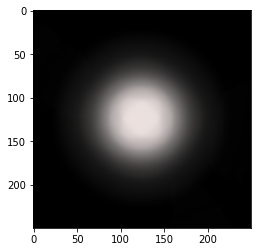

In [15]:
plt.imshow(rice_dataset['rice_img'].astype('int').to_numpy())